# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.550477,True,7.841335
1,0.215338,True,3.753403
2,-0.702811,False,-1.430678
3,2.570619,False,5.683169
4,1.583350,True,9.695174
...,...,...,...
995,0.861502,True,6.195915
996,0.423040,False,-0.300496
997,1.403314,True,5.078044
998,1.449474,False,3.463942


<AxesSubplot:xlabel='v0'>

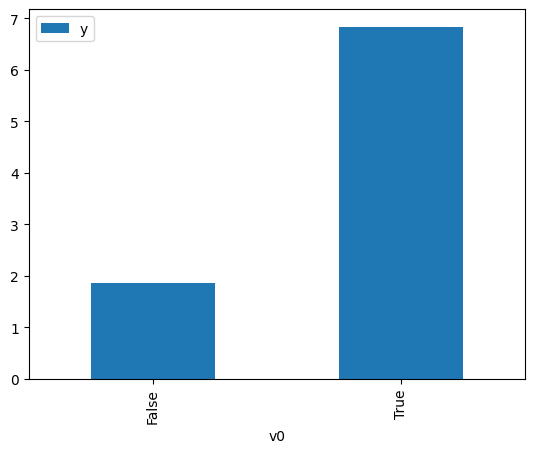

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

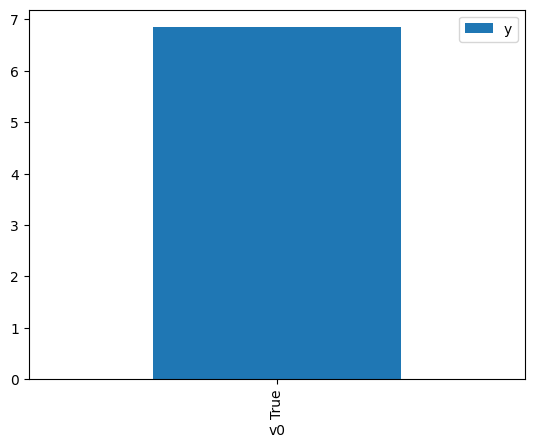

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,2.969143,False,6.856161,0.354589,2.820163
1,0.565090,False,1.839057,0.461866,2.165130
2,1.197786,False,2.435378,0.432849,2.310272
3,2.833821,False,5.571488,0.360357,2.775027
4,1.534570,False,2.536291,0.417577,2.394768
...,...,...,...,...,...
995,-0.315777,False,-1.011258,0.502655,1.989436
996,0.193352,False,2.191477,0.479049,2.087469
997,0.612662,False,-0.217551,0.459673,2.175460
998,-0.137592,False,-1.162013,0.494389,2.022697


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.974735,True,6.709170,0.556963,1.795451
1,-0.171980,True,5.765789,0.504016,1.984066
2,4.434407,True,13.700631,0.704916,1.418609
3,0.282246,True,4.463726,0.525066,1.904522
4,0.376999,True,4.642779,0.529448,1.888758
...,...,...,...,...,...
995,1.428217,True,7.036380,0.577616,1.731255
996,-1.505856,True,2.195899,0.442394,2.260427
997,-0.041601,True,6.752587,0.510062,1.960544
998,1.259415,True,9.350940,0.569956,1.754522


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.967
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                          1.470e+04
Date:                Tue, 06 Sep 2022   Prob (F-statistic):                        0.00
Time:                        07:39:37   Log-Likelihood:                         -1450.4
No. Observations:                1000   AIC:                                      2905.
Df Residuals:                     998   BIC:                                      2915.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8639      0.029     64.441      0.000       1.807       1.921
x2             5.0195      0.053     94.407      0.000       4.915       5.124
==============================================================================
Omnibus:                        1.627   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.443   Jarque-Bera (JB):                1.589
Skew:                           0.036   Prob(JB):                        0.452
Kurtosis:                       2.818   Cond. No.                         2.49
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""